In this assignment students have to make ARIMA model over shampoo sales data and 
check the MSE between predicted and actual value.
Student can download data in .csv format from the following link:

https://datamarket.com/data/set/22r0/sales-of-shampoo-over-a-three-year- period#!ds=22r0&display=line

In [1]:
# Import the required libraries
from pandas import datetime
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from scipy import stats
from statsmodels.graphics.api import qqplot
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline

In [2]:
# Define a parser for the date value in the dataset and add '190' as the prefix for the year values. 
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

In [3]:
# Read the data into series dataframe. 
series = pd.read_csv('shampoo-sales', header=0, nrows=36, parse_dates=[0], index_col=0, squeeze=True, 
                     date_parser=parser)
series

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
1901-06-01    168.5
1901-07-01    231.8
1901-08-01    224.5
1901-09-01    192.8
1901-10-01    122.9
1901-11-01    336.5
1901-12-01    185.9
1902-01-01    194.3
1902-02-01    149.5
1902-03-01    210.1
1902-04-01    273.3
1902-05-01    191.4
1902-06-01    287.0
1902-07-01    226.0
1902-08-01    303.6
1902-09-01    289.9
1902-10-01    421.6
1902-11-01    264.5
1902-12-01    342.3
1903-01-01    339.7
1903-02-01    440.4
1903-03-01    315.9
1903-04-01    439.3
1903-05-01    401.3
1903-06-01    437.4
1903-07-01    575.5
1903-08-01    407.6
1903-09-01    682.0
1903-10-01    475.3
1903-11-01    581.3
1903-12-01    646.9
Name: Sales of shampoo over a three year period, dtype: float64

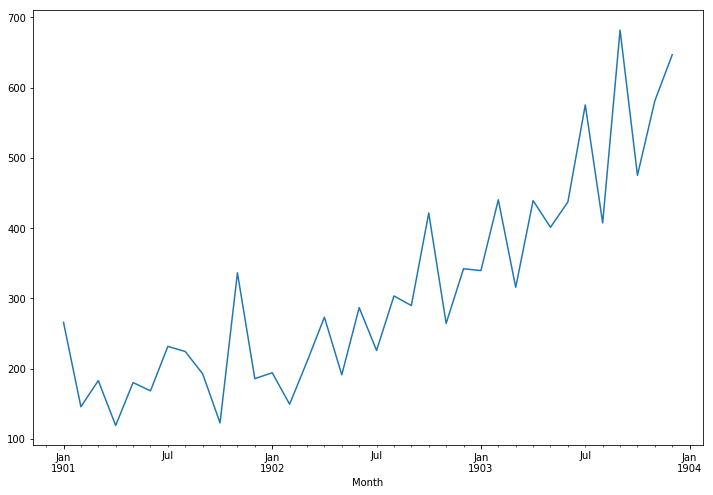

In [4]:
# Visualize the data values. 
series.plot(figsize=(12,8));

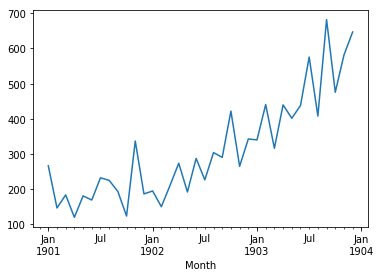

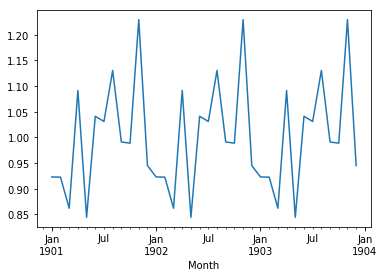

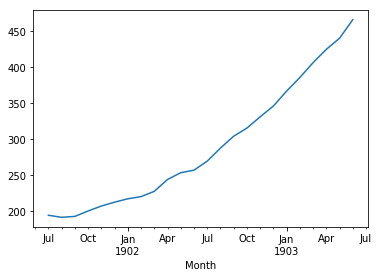

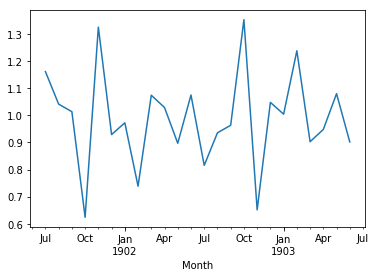

In [5]:
# Decompose the series to see the trend, seasonal and residual components 
result = seasonal_decompose(series, model="multiplicative")
result.observed.plot()
plt.show()
result.seasonal.plot()
plt.show()
result.trend.plot()
plt.show()
result.resid.plot()
plt.show()

The plots shows that the data is not stationary. 

In [6]:
# Check the Durbin Watson value to see if the data is autocorrelated. 
sm.stats.durbin_watson(series)

0.09548538187456361

The value is 0.095 and that shows the data has high correlation. 

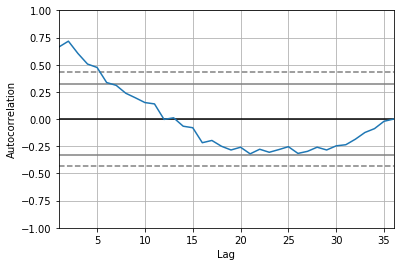

In [7]:
# Create an autocorrelation plot. 
autocorrelation_plot(series)
plt.show()

The above auto correlation plot shows that there is autocorrelation present in the data. 

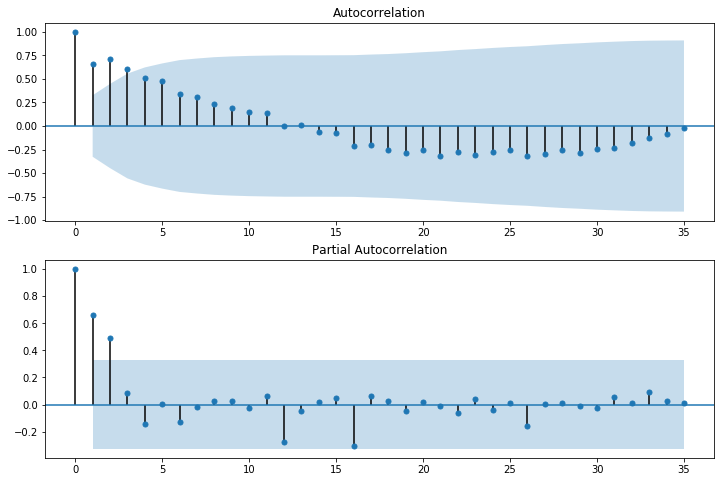

In [8]:
# Create ACF (Auto correlation) and PACF (partial Auto correlation) plots. 
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(series.values.squeeze(), ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(series, method='ywmle', ax=ax2)

Using the above ACF plot, we can see that 5 values that have correlation above 0.5 in the first part of the exponential graph. So use 5 as the value for 'p' in the ARIMA model.  

In [9]:
# Examine the ADF stats to identify if the values are stationary or not.
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 3.060142
p-value: 1.000000
Critical Values:
	1%: -3.724
	5%: -2.986
	10%: -2.633


The value of ADF is positive. This shows that the values are non stationary.

Finding values of 'p', 'd' and 'q' to be used in the ARIMA model. 

'p' - Autocorrelation factor. Looking at the ACF, approximate the value to be used.

'd' - use a differenciation value of '1' to make the series stationary. Using '2' for this parameter will make the values overdifferentiated. The Standard Deviation has lowest value when the differenciation value is '1'.

'q' - Moving Average Value. Looking at the PACF, approximate the value to be used. 

Once the differenciation is done, check by modifying the values of p and q to get the best fit. 

Using a value of 5 for AR and 0 for MA and 1 for differenciation gives the best fit. 

In [10]:
model = ARIMA(series, order=(5,1,0),freq='MS')
model_fit = model.fit(disp=0)
print(model_fit.summary())

                                          ARIMA Model Results                                          
Dep. Variable:     D.Sales of shampoo over a three year period   No. Observations:                   35
Model:                                          ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                                                css-mle   S.D. of innovations             64.241
Date:                                         Sun, 27 Jan 2019   AIC                            406.340
Time:                                                 16:59:00   BIC                            417.227
Sample:                                             02-01-1901   HQIC                           410.098
                                                  - 12-01-1903                                         
                                                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

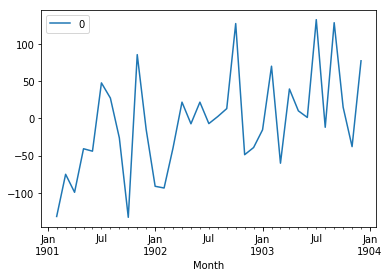

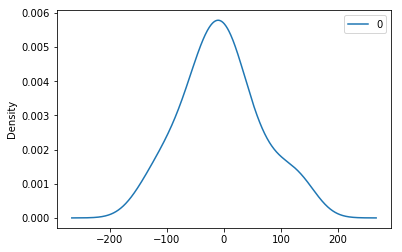

                0
count   35.000000
mean    -5.495218
std     68.132882
min   -133.296637
25%    -42.477890
50%     -7.186512
75%     24.748330
max    133.237936


In [11]:
# Plot the residuals of the model. 
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [12]:
# Check the Durbin Watson value for the residuals
sm.stats.durbin_watson(model_fit.resid.values)

1.713403990074023

The Durbin Watson value is nearer to 2. So shows less correlation for the residuals. 

In [13]:
# Perform a normal test on the residuals. 
model_resid = model_fit.resid 
stats.normaltest(model_resid)

NormaltestResult(statistic=0.4363895638631994, pvalue=0.803968827813053)

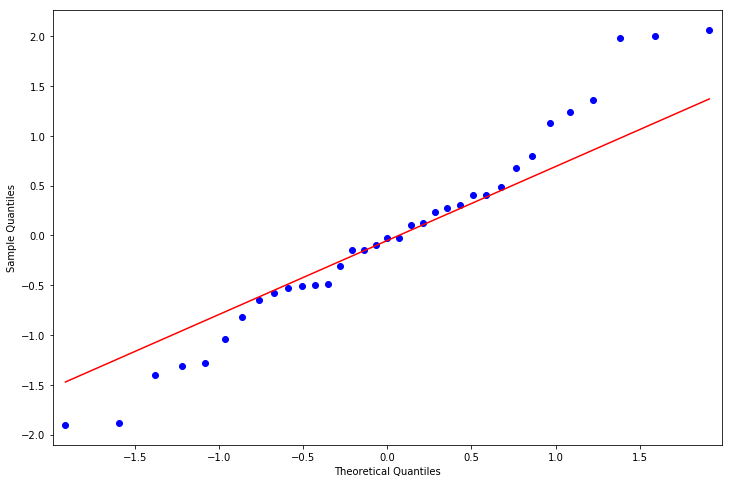

In [14]:
# Plot the residuals
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(model_resid, line='q', ax=ax, fit=True)

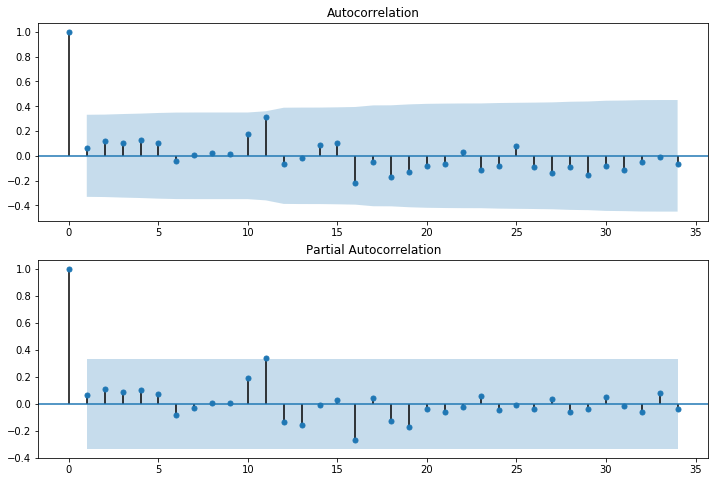

In [15]:
# Plot the ACF and PACF of the residuals to visualize the correlation of the residuals.  
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(model_resid.values.squeeze(), lags=34, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(model_resid, lags=34, method='ywmle', ax=ax2)

In [16]:
# Test the model with train and test data 
size=int(len(series)*0.7)
train, test = series.values[0:size], series.values[size:len(series)]
len(train), len(test)

(25, 11)

In [17]:
# Create train list and empty list to store the predictions 
X=list(train)
predictions=[]

In [18]:
# Train the model with train data and predict for the next value.
for t in range (len(test)):
    model = ARIMA(X, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    X.append(test[t])
    print('predicted=%f, expected=%f' % (yhat, test[t]))

predicted=387.376466, expected=440.400000
predicted=348.154255, expected=315.900000
predicted=386.308811, expected=439.300000
predicted=356.082028, expected=401.300000
predicted=446.379518, expected=437.400000
predicted=394.737242, expected=575.500000
predicted=434.915541, expected=407.600000
predicted=507.923456, expected=682.000000
predicted=435.482818, expected=475.300000
predicted=652.743768, expected=581.300000
predicted=546.343465, expected=646.900000


In [19]:
# Print the Root mean squared error. 
error = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % error)

Test RMSE: 90.106


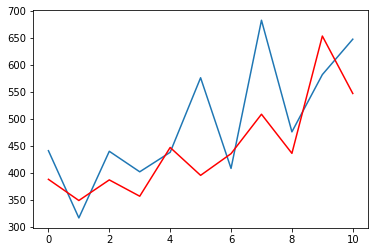

In [20]:
# Plot the values of test vs predictions. 
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()